In [587]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import figure_functions as ff

from mpc_fly import MpcFlyWind

import utils

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import visualkeras

pd.set_option('display.max_columns', None)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [588]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8782625230923108263
 xla_global_id: -1]

In [589]:
tf.config.list_physical_devices('GPU')

[]

# Load data
Data set consists of concatenated trajectories of a simulated fly flying in the presence of constant wind

In [592]:
data_path = os.path.join(os.path.pardir, 'data', 'trajectory_data.csv')
data_path

'..\\data\\trajectory_data.csv'

In [593]:
data = pd.read_csv(data_path)
data

,Unnamed: 0,time,v_para,v_perp,phi,phidot,w,zeta,I,m,C_para,C_perp,C_phi,d,km1,km2,km3,km4,ks1,ks2,ks3,ks4,ks5,ks6,ks7,g,psi,of,a_para,a_perp,a,gamma,v_para_dot,v_perp_dot,v_para_dot_uncal,v_perp_dot_uncal,phiddot,q,alpha,dir_of_travel,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,wdot,zetadot,u_g,u_psi,phi_uncal,gamma_uncal,psi_uncal,alpha_uncal,phi_y,phi_x,psi_y,psi_x,gamma_y,gamma_x,alpha_y,alpha_x,zeta_x,zeta_y,phi_uncal_y,phi_uncal_x,psi_uncal_y,psi_uncal_x,gamma_uncal_y,gamma_uncal_x,alpha_uncal_y,alpha_uncal_x
0,0,0.00,0.500000,0.000000e+00,0.000000,9.921269,0.100000,0.000000e+00,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.000000e+00,1.666667,0.400000,0.000000,0.400000,0.000000,0.006325,-0.534073,0.006325,-0.534073,-261.491783,0.534111,-1.558954,0.000000,0.500000,0.000000,0.000000,0.000000,0.589817,1.106640,135.470200,0.000041,8.118968e-06,1.254008,1.081115,0.000000,0.000000,0.000000e+00,-1.558954,0.000000,1.000000,0.000000e+00,1.0,0.000000,1.000000,-0.999930,0.011842,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000,1.000000,-0.999930,0.011842
1,1,0.01,0.499984,-3.407896e-05,0.088159,7.887961,0.100000,8.118968e-08,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.499984,-6.816015e-05,1.666612,0.400372,0.008770,0.400468,0.021902,0.003870,0.431119,0.003870,0.431119,-154.508489,0.431136,1.561819,0.088091,0.498045,0.043987,0.004990,0.000220,0.589817,1.106640,135.470200,0.000041,8.118968e-06,1.254008,1.081115,0.088159,0.021902,-6.816015e-05,1.561819,0.088045,0.996117,-6.816015e-05,1.0,0.021900,0.999760,0.999960,0.008977,1.000000,8.118968e-08,0.088045,0.996117,-6.816015e-05,1.0,0.021900,0.999760,0.999960,0.008977
2,2,0.02,0.500000,3.445220e-06,0.167167,7.911593,0.100000,-1.191436e-08,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,6.890438e-06,1.666667,0.401394,0.016642,0.401739,0.041438,-0.001871,-0.024507,-0.001871,-0.024507,1.795751,0.024578,4.636204,0.167174,0.493030,0.083198,0.009946,0.000856,0.589811,1.007297,217.394968,-0.000040,-9.310405e-06,1.167272,1.041078,0.167167,0.041438,6.890438e-06,-1.646981,0.166389,0.986060,6.890438e-06,1.0,0.041426,0.999142,-0.997099,-0.076111,1.000000,-1.191436e-08,0.166389,0.986060,6.890438e-06,1.0,0.041426,0.999142,-0.997099,-0.076111
3,3,0.03,0.500000,1.563718e-06,0.249344,8.474770,0.100000,2.020242e-09,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,3.127436e-06,1.666667,0.403093,0.024678,0.403847,0.061146,-0.007591,-0.150853,-0.007591,-0.150853,42.795119,0.151044,4.662109,0.249348,0.484537,0.123386,0.014833,0.001889,0.590882,1.057925,254.123175,-0.000002,1.393461e-06,1.211754,1.061428,0.249344,0.061146,3.127436e-06,-1.621076,0.246769,0.969074,3.127436e-06,1.0,0.061108,0.998131,-0.998736,-0.050259,1.000000,2.020242e-09,0.246769,0.969074,3.127436e-06,1.0,0.061108,0.998131,-0.998736,-0.050259
4,4,0.04,0.500000,3.899027e-07,0.336091,8.842419,0.100000,7.406498e-09,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,7.798055e-07,1.666666,0.405595,0.032980,0.406933,0.081135,-0.009381,-0.107245,-0.009381,-0.107245,27.937168,0.107655,4.625139,0.336092,0.472025,0.164900,0.019616,0.003330,0.594117,1.126991,256.455923,-0.000002,5.386256e-07,1.274003,1.085649,0.336091,0.081135,7.798055e-07,-1.658047,0.329799,0.944051,7.798055e-07,1.0,0.081046,0.996710,-0.996196,-0.087140,1.000000,7.406498e-09,0.329799,0.944051,7.798055e-07,1.0,0.081046,0.996710,-0.996196,-0.087140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391675,46,0.46,0.499973,-3.823889e-05,2.942751,69.194399,9.999990,6.086827e+00,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1

In [594]:
data['phi'] = utils.wrapToPi(data['phi'])
data['psi'] = utils.wrapToPi(data['psi'])
data['gamma'] = utils.wrapToPi(data['gamma'])

# Pull out data

In [595]:
# Input variables are fly heading and air speed angle
input_names =  ['phi', 'gamma']
# input_names =  ['phi_x', 'phi_y', 'gamma_x', 'gamma_y']

In [600]:
# Output variables to predict are the x,y unit vector components of the ambient wind direction (avoids predicting a circular variable)
output_names =  ['zeta_x', 'zeta_y']

In [602]:
# Keep inputs, outptus, and time
Z = data.loc[:, ['time'] + input_names + output_names]
Z

,time,phi,gamma,zeta_x,zeta_y
0,0.00,0.000000,0.000000,1.000000,0.000000e+00
1,0.01,0.088159,0.021902,1.000000,8.118968e-08
2,0.02,0.167167,0.041438,1.000000,-1.191436e-08
3,0.03,0.249344,0.061146,1.000000,2.020242e-09
4,0.04,0.336091,0.081135,1.000000,7.406498e-09
...,...,...,...,...,...
391675,0.46,2.942751,0.002361,0.980784,-1.950992e-01
391676,0.47,-2.652085,-0.655384,0.980785,-1.950903e-01
391677,0.48,-1.995238,-1.294573,0.980788,-1.950782e-01
391678,0.49,-1.414198,-1.876017,0.980790,-1.950680e-01


In [603]:
n_point = Z.shape[0]
n_point

391680

# Separate individual trajectories

In [604]:
startI = np.where(Z.time.values == 0.0)[0]
n_traj = startI.shape[0]
n_traj

7680

In [605]:
Z_list = []
# startI = np.where(Z.time.values == 0.0)[0] # find start of seperate trajectories
for n in range(n_traj):
    if n == (n_traj - 1):
        endI = Z.shape[0]
    else:
        endI = (startI[n + 1])

    traj = Z.iloc[startI[n]:endI, :]
    Z_list.append(traj)

In [606]:
len(Z_list) * 51

391680

# Augment training data with prior time-steps

In [607]:
window_size = 4 

In [608]:
Zaug = []
for z in Z_list:
    zaug = utils.collect_offset_rows(z, aug_column_names=input_names,
                                     keep_column_names=output_names,
                                     w=window_size,
                                     direction='backward')
    Zaug.append(zaug)

Zaug = pd.concat(Zaug, ignore_index=True)

In [610]:
Zaug

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3,zeta_x,zeta_y
0,0.249344,0.167167,0.088159,0.000000,0.061146,0.041438,0.021902,0.000000,1.000000,2.020242e-09
1,0.336091,0.249344,0.167167,0.088159,0.081135,0.061146,0.041438,0.021902,1.000000,7.406498e-09
2,0.423994,0.336091,0.249344,0.167167,0.100286,0.081135,0.061146,0.041438,1.000000,7.939773e-09
3,0.508347,0.423994,0.336091,0.249344,0.117411,0.100286,0.081135,0.061146,1.000000,6.376379e-09
4,0.584930,0.508347,0.423994,0.336091,0.131758,0.117411,0.100286,0.081135,1.000000,4.309555e-09
...,...,...,...,...,...,...,...,...,...,...
368635,2.942751,2.266280,1.637562,1.081504,0.002361,0.648734,1.260042,1.815188,0.980784,-1.950992e-01
368636,-2.652085,2.942751,2.266280,1.637562,-0.655384,0.002361,0.648734,1.260042,0.980785,-1.950903e-01
368637,-1.995238,-2.652085,2.942751,2.266280,-1.294573,-0.655384,0.002361,0.648734,0.980788,-1.950782e-01
368638,-1.414198,-1.995238,-2.652085,2.942751,-1.876017,-1.294573,-0.655384,0.002361,0.980790,-1.950680e-01


# Save augmented data

In [611]:
save_path = os.path.join(os.path.pardir, 'data', 'trajectory_data_augmented.csv')
Zaug.to_csv(path_or_buf=save_path)

In [612]:
# Reload
Zaug = pd.read_csv(save_path)
Zaug = Zaug.iloc[:, 1:]
Zaug

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3,zeta_x,zeta_y
0,0.249344,0.167167,0.088159,0.000000,0.061146,0.041438,0.021902,0.000000,1.000000,2.020242e-09
1,0.336091,0.249344,0.167167,0.088159,0.081135,0.061146,0.041438,0.021902,1.000000,7.406498e-09
2,0.423994,0.336091,0.249344,0.167167,0.100286,0.081135,0.061146,0.041438,1.000000,7.939773e-09
3,0.508347,0.423994,0.336091,0.249344,0.117411,0.100286,0.081135,0.061146,1.000000,6.376379e-09
4,0.584930,0.508347,0.423994,0.336091,0.131758,0.117411,0.100286,0.081135,1.000000,4.309555e-09
...,...,...,...,...,...,...,...,...,...,...
368635,2.942751,2.266280,1.637562,1.081504,0.002361,0.648734,1.260042,1.815188,0.980784,-1.950992e-01
368636,-2.652085,2.942751,2.266280,1.637562,-0.655384,0.002361,0.648734,1.260042,0.980785,-1.950903e-01
368637,-1.995238,-2.652085,2.942751,2.266280,-1.294573,-0.655384,0.002361,0.648734,0.980788,-1.950782e-01
368638,-1.414198,-1.995238,-2.652085,2.942751,-1.876017,-1.294573,-0.655384,0.002361,0.980790,-1.950680e-01


# Pull out training data

In [613]:
n_input = len(input_names) * window_size
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 8
Output: 2


In [614]:
# Input data
X = Zaug.iloc[:, 0:n_input]
X

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3
0,0.249344,0.167167,0.088159,0.000000,0.061146,0.041438,0.021902,0.000000
1,0.336091,0.249344,0.167167,0.088159,0.081135,0.061146,0.041438,0.021902
2,0.423994,0.336091,0.249344,0.167167,0.100286,0.081135,0.061146,0.041438
3,0.508347,0.423994,0.336091,0.249344,0.117411,0.100286,0.081135,0.061146
4,0.584930,0.508347,0.423994,0.336091,0.131758,0.117411,0.100286,0.081135
...,...,...,...,...,...,...,...,...
368635,2.942751,2.266280,1.637562,1.081504,0.002361,0.648734,1.260042,1.815188
368636,-2.652085,2.942751,2.266280,1.637562,-0.655384,0.002361,0.648734,1.260042
368637,-1.995238,-2.652085,2.942751,2.266280,-1.294573,-0.655384,0.002361,0.648734
368638,-1.414198,-1.995238,-2.652085,2.942751,-1.876017,-1.294573,-0.655384,0.002361


In [615]:
# Output data
Y = Zaug.iloc[:, n_input:]
Y

,zeta_x,zeta_y
0,1.000000,2.020242e-09
1,1.000000,7.406498e-09
2,1.000000,7.939773e-09
3,1.000000,6.376379e-09
4,1.000000,4.309555e-09
...,...,...
368635,0.980784,-1.950992e-01
368636,0.980785,-1.950903e-01
368637,0.980788,-1.950782e-01
368638,0.980790,-1.950680e-01


# Construct model
Use a feedforward network with a few dense layers

In [622]:
model = Sequential()
model.add(Dense(50, input_dim=n_input, activation='relu'))
model.add(Dense(50, input_dim=n_input, activation='relu'))
model.add(Dense(20, input_dim=n_input, activation='relu'))
model.add(Dense(n_output, activation='linear'))

In [623]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [624]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 50)                450       
                                                                 
 dense_45 (Dense)            (None, 50)                2550      
                                                                 
 dense_46 (Dense)            (None, 20)                1020      
                                                                 
 dense_47 (Dense)            (None, 2)                 42        
                                                                 
Total params: 4062 (15.87 KB)
Trainable params: 4062 (15.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [625]:
visualkeras.layered_view(model)

# Train model

In [626]:
model.fit(X, Y, epochs=150, batch_size=256, verbose=1)

Epoch 1/150
1440/1440 [==============================] - 4s 2ms/step - loss: 0.1763 - mae: 0.3213
Epoch 2/150
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0947 - mae: 0.2285
Epoch 3/150
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0688 - mae: 0.1930
Epoch 4/150
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0545 - mae: 0.1709
Epoch 5/150
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0462 - mae: 0.1566
Epoch 6/150
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0411 - mae: 0.1467
Epoch 7/150
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0373 - mae: 0.1392
Epoch 8/150
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0343 - mae: 0.1329
Epoch 9/150
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0325 - mae: 0.1288
Epoch 10/150
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0308 - mae: 0.1248
Epoch 11/150
1440/1

# Run model on training data

In [638]:
Y_train = model.predict(X, batch_size=4096)
Y_train.shape

90/90 [==============================] - 0s 2ms/step


(368640, 2)

In [639]:
zeta_train = np.arctan2(Y_train[:, 1], Y_train[:, 0])
zeta_true = np.arctan2(Y.values[:, 1], Y.values[:, 0])

Text(0.5, 0, 'True wind direction (rad)')

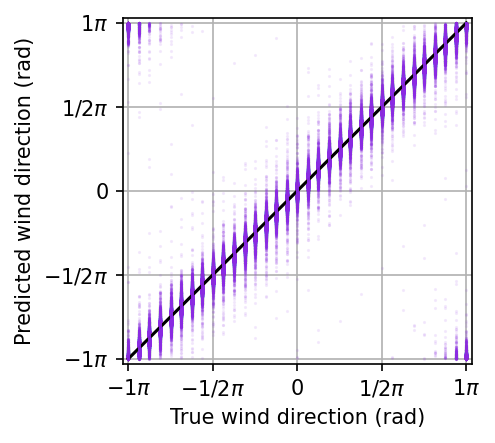

In [640]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

zeta_line = np.arange(-np.pi, 1.01*np.pi, np.pi/2)

ax.plot(zeta_line, zeta_line, '-', color='black')
ax.plot(zeta_true, zeta_train, '.', markersize=1, alpha=0.1, color='blueviolet')

ff.pi_yaxis(ax)
ff.pi_xaxis(ax)
ax.grid()

ax.set_ylim(-np.pi - 0.1, np.pi + 0.1)
ax.set_xlim(-np.pi - 0.1, np.pi + 0.1)

ax.set_ylabel('Predicted wind direction (rad)')
ax.set_xlabel('True wind direction (rad)')

# Save model

In [642]:
save_nn_path = os.path.join(os.path.pardir, 'data', 'network_trained.keras')
save_nn_path

'..\\data\\network_trained.keras'

In [643]:
model.save(save_nn_path)

# Reload model

In [644]:
model_load = keras.models.load_model(save_nn_path)

# Test model on new data

## Set trajectory

In [645]:
fs = 100.0
dt = 1/fs
T = 1.0
n_point = int((T * fs) + 1)
tsim = dt * (np.linspace(1.0, n_point, n_point) - 1)

In [646]:
v_para = 0.5 * np.ones_like(tsim)
v_perp = 0.0 * np.ones_like(tsim)
phi = 0.4*np.pi + np.pi/2 * np.sin(2*np.pi*1.0*tsim)
w = 0.4 * np.ones_like(tsim)
zeta = 0.0 * (np.pi) * np.ones_like(tsim)

# zeta = 0.0*np.pi + np.pi * np.sin(2*np.pi*1.0*tsim)
# v_para = 0.5 + 0.2 * np.sin(2*np.pi*3.3*tsim)
phi = 1.2*(np.pi/1)* np.ones_like(tsim)
phi[30:] = phi[0] + np.pi/2
phi = np.unwrap(utils.wrapToPi(phi))
# w = 7.0 + 1.2*np.sin(2*np.pi*2.0*tsim)


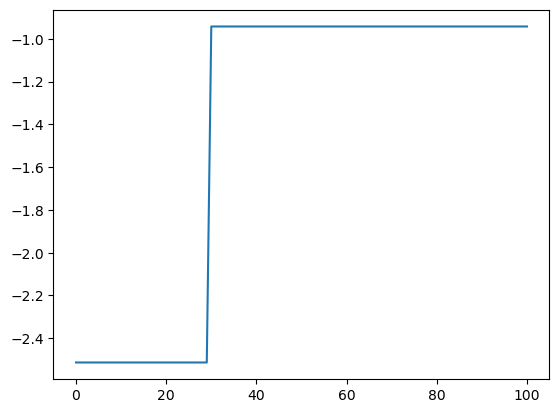

In [647]:
plt.plot(phi)

## Simulate trajectory 

In [648]:
mpc = MpcFlyWind(v_para, v_perp, phi, w, zeta, x0=None, dt=dt, n_horizon=20, r_weight=1e-6)

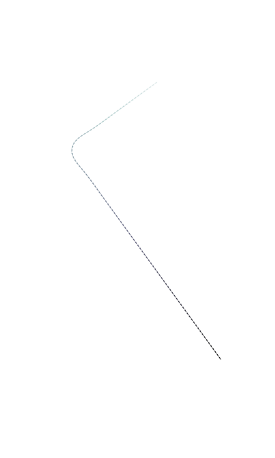

In [649]:
mpc.plot_trajectory(cmap=None, size=5, dpi=100, arrow_size=0.005, nskip=0)

In [650]:
data = mpc.sim_data_df
np.round(data, 5)

,time,v_para,v_perp,phi,phidot,w,zeta,I,m,C_para,C_perp,C_phi,d,km1,km2,km3,km4,ks1,ks2,ks3,ks4,ks5,ks6,ks7,g,psi,of,a_para,a_perp,a,gamma,v_para_dot,v_perp_dot,v_para_dot_uncal,v_perp_dot_uncal,phiddot,q,alpha,dir_of_travel,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,wdot,zetadot,u_g,u_psi,phi_uncal,gamma_uncal,psi_uncal,alpha_uncal,phi_y,phi_x,psi_y,psi_x,gamma_y,gamma_x,alpha_y,alpha_x,zeta_x,zeta_y,phi_uncal_y,phi_uncal_x,psi_uncal_y,psi_uncal_x,gamma_uncal_y,gamma_uncal_x,alpha_uncal_y,alpha_uncal_x
0,0.00,0.50000,0.00000,-2.51327,0.00000,0.4,0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,0.00000,1.66667,0.82361,-0.23511,0.85651,-0.27807,-0.00320,0.00092,-0.00320,0.00092,0.00039,0.00333,2.86294,-2.51327,-0.40451,-0.29389,0.00000,0.00000,1.21039,-0.34553,0.00021,-0.00014,-0.00002,1.25874,-0.27807,-2.51327,-0.27807,0.00000,2.86294,-0.58779,-0.80902,0.00000,1.0,-0.27450,0.96159,0.27506,-0.96143,1.0,0.0,-0.58779,-0.80902,0.00000,1.0,-0.27450,0.96159,0.27506,-0.96143
1,0.01,0.49997,0.00001,-2.51327,0.00000,0.4,-0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.49997,0.00002,1.66656,0.82357,-0.23510,0.85647,-0.27807,-0.00301,0.00086,-0.00301,0.00086,0.00023,0.00313,2.86410,-2.51326,-0.40448,-0.29388,-0.00404,-0.00294,1.21039,-0.34553,0.00021,-0.00014,-0.00002,1.25874,-0.27807,-2.51327,-0.27807,0.00002,2.86410,-0.58779,-0.80902,0.00002,1.0,-0.27450,0.96159,0.27395,-0.96174,1.0,-0.0,-0.58779,-0.80902,0.00002,1.0,-0.27450,0.96159,0.27395,-0.96174
2,0.02,0.50000,0.00000,-2.51327,0.00000,0.4,-0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,0.00000,1.66667,0.82361,-0.23511,0.85651,-0.27807,0.00300,-0.00086,0.00300,-0.00086,-0.00004,0.00312,6.00546,-2.51327,-0.40451,-0.29389,-0.00809,-0.00588,1.21194,-0.34597,0.00004,0.00011,0.00002,1.26035,-0.27807,-2.51327,-0.27807,0.00000,-0.27772,-0.58779,-0.80902,0.00000,1.0,-0.27450,0.96159,-0.27417,0.96168,1.0,-0.0,-0.58779,-0.80902,0.00000,1.0,-0.27450,0.96159,-0.27417,0.96168
3,0.03,0.50000,-0.00000,-2.51327,0.00000,0.4,0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,-0.00000,1.66667,0.82361,-0.23511,0.85651,-0.27807,0.00002,-0.00000,0.00002,-0.00000,-0.00009,0.00002,6.03590,-2.51327,-0.40451,-0.29389,-0.01213,-0.00882,1.21119,-0.34576,-0.00001,0.00003,0.00000,1.25958,-0.27807,-2.51327,-0.27807,-0.00000,-0.24729,-0.58779,-0.80902,-0.00000,1.0,-0.27450,0.96159,-0.24478,0.96958,1.0,0.0,-0.58779,-0.80902,-0.00000,1.0,-0.27450,0.96159,-0.24478,0.96958
4,0.04,0.50000,-0.00000,-2.51327,0.00000,0.4,0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,-0.00000,1.66667,0.82361,-0.23511,0.85651,-0.27807,-0.00000,0.00000,-0.00000,0.00000,-0.00006,0.00000,9.07061,-2.51327,-0.40451,-0.29389,-0.01618,-0.01176,1.21119,-0.34576,-0.00001,0.00001,0.00000,1.25957,-0.27807,-2.51327,-0.27807,-0.00000,2.78742,-0.58779,-0.80902,-0.00000,1.0,-0.27450,0.96159,0.34681,-0.93793,1.0,0.0,-0.58779,-0.80902,-0.00000,1.0,-0.27450,0.96159,0.34681,-0.93793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.50000,0.00000,-0.94248,0.00001,0.4,-0.0,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,0.00000,1.66667,0.26489,-0.32361,0.41819,-0.88485,0.00000,0.00000,0.00000,0.00000,-0.00008,0.00000,38.62309,-0.94248,0.29389,-0.40451,0.07537,-0.36039,0.38954,-0.47589,0.00027,-0.00000,-0.00000,0.61499,-0.88485,-0.94248,-0.88485,0.00000,0.92398,-0.80902,0.58778,0.00000,1.0,-0.77382,0.63341,0.79801,0.60265,1.0,-0.0,-0.80902,0.58778,0.00000,1.0,-0.77382,0.63341,0.79801,0.60265
97,0.97,0.50000,0.00000,-0.94248,0.00001,0.4,-0.0,0.52,0.25,1.47059,1.47059,27

## Get testing data

In [657]:
Z = data.loc[:, input_names + output_names]
Z['phi'] = utils.wrapToPi(Z['phi'])
Z['gamma'] = utils.wrapToPi(Z['gamma'])
# Z

In [658]:
Zaug = utils.collect_offset_rows(Z, aug_column_names=input_names,
                                 keep_column_names=output_names,
                                 w=window_size,
                                 direction='backward')
# Zaug

## Pull out input & output data

In [659]:
X = Zaug.iloc[:, 0:n_input]
X

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3
0,-2.513274,-2.513274,-2.513274,-2.513274,-0.278073,-0.278073,-0.278072,-0.278073
1,-2.513274,-2.513274,-2.513274,-2.513274,-0.278073,-0.278073,-0.278073,-0.278072
2,-2.513274,-2.513274,-2.513274,-2.513274,-0.278073,-0.278073,-0.278073,-0.278073
3,-2.513274,-2.513274,-2.513274,-2.513274,-0.278073,-0.278073,-0.278073,-0.278073
4,-2.513274,-2.513274,-2.513274,-2.513274,-0.278073,-0.278073,-0.278073,-0.278073
...,...,...,...,...,...,...,...,...
93,-0.942479,-0.942479,-0.942479,-0.942479,-0.884851,-0.884851,-0.884850,-0.884850
94,-0.942479,-0.942479,-0.942479,-0.942479,-0.884851,-0.884851,-0.884851,-0.884850
95,-0.942479,-0.942479,-0.942479,-0.942479,-0.884851,-0.884851,-0.884851,-0.884851
96,-0.942479,-0.942479,-0.942479,-0.942479,-0.884851,-0.884851,-0.884851,-0.884851


In [660]:
Y = Zaug.iloc[:, n_input:]
# Y

## Run

In [661]:
Y_nn = model_load.predict(X, batch_size=32)
zeta_true = np.arctan2(Y.values[:, 1], Y.values[:, 0])
zeta_nn = np.arctan2(Y_nn[:, 1], Y_nn[:, 0])

4/4 [==============================] - 0s 2ms/step


## Plot

Text(0, 0.5, 'rad')

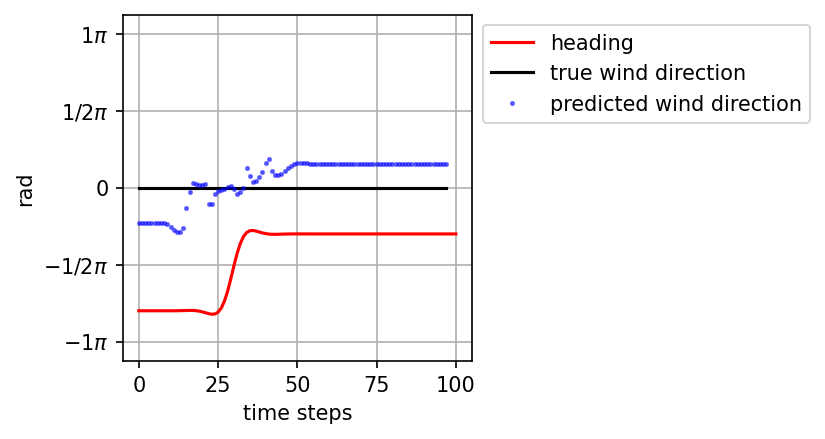

In [662]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

ax.plot(mpc.sim_data_df.phi, 'r', label='heading')
ax.plot(zeta_true, 'k', label='true wind direction', markersize=3)
ax.plot(utils.wrapToPi(zeta_nn), '.', label='predicted wind direction',  markersize=3, alpha=0.5, color='blue')

ff.pi_yaxis(ax)
ax.grid()
ax.legend(bbox_to_anchor=(2.0, 1.0))

ax.set_xlabel('time steps')
ax.set_ylabel('rad')